## 코랩을 통하여 실행한 Attention 중심의 Seq2Seq 언어 학습

마지막 부분의 translate 함수는 조정 중에 있습니다만, 
1차적으로 이해한 부분까지는 최대한 설명해놓겠습니다.

In [ ]:
#패키지 인스톨
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install torchtext==0.10.01

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

#필요 라이브러리 임포트 부분
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

In [ ]:
#필요 데이터 로딩
!python3 -m spacy download de_core_news_sm
!python3 -m spacy download en_core_web_sm
import en_core_web_sm, de_core_news_sm
spacy_en = spacy.load('en_core_web_sm')
spacy_de = spacy.load('de_core_news_sm')

2023-04-03 16:18:35.033597: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 55.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
2023-04-03 16:18:51.837104: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 84.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

# SOS, EOS를 문장 앞과 뒤에 붙이는 것으로 학습 모델에 적용 가능한 입력 형식으로 변환

In [ ]:
SRC = Field(tokenize = tokenize_de, init_token = '', eos_token = '', lower = True)

TRG = Field(tokenize = tokenize_en, init_token = '', eos_token = '', lower = True)

# Data Split 구간

In [ ]:

train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))

# .build_vocab 함수를 통해 training data를 위한 단어들 생성
## 최소 2번 이상 나온 단어들에만 적용

In [ ]:

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)
     

# GPU 세팅

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# iterator 세팅

In [ ]:

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

# ENCODER

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded) #...............................(1)


        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))) #.......(2)
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden


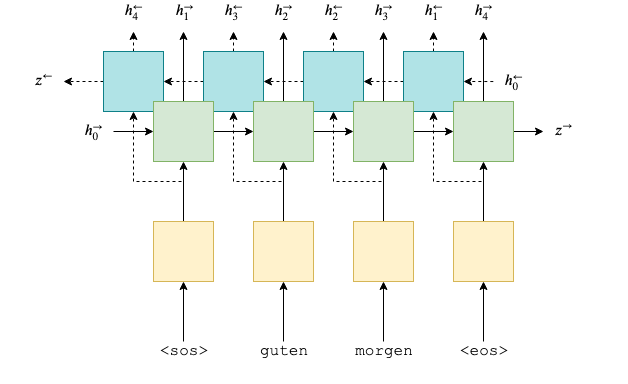

INPUT

하나의 문장(ex : 'guten, morgan')이 [ sos, 'guten', 'morgan', eos ]로 입력되고, 해당 전처리된 데이터가 embedding vector로 변환되어 GRU층에 전달됩니다.


GRU층은 forward와 backward 벡터를 둘 다 만들어 내는데, forward는 일반적인 context vector를 리턴하고 backward는 context vector의 반대방향의 벡터를 아래와 같이 반환합니다.
1. $\overrightarrow{x_0}$ = sos
2. $\overleftarrow{x_1}$ = guten
3. $\overleftarrow{x_0}$ = eos
4. $\overleftarrow{x_1}$ = morgen

이와 같이 생성된 벡터를 임베딩 함수를 거쳐 GRU에 넣어 각 $h_t$(hidden state)를 계산합니다. 이 부분은 위 코드의 주석 (1)에 해당합니다.

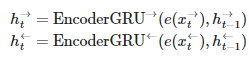


코드의 (2)는 linear layer(g)에 양방향 벡터를 통과시켜 디코더에 전달해 줄 단일 context vector $s_0$를 생성하며 이는 hidden vector와 같습니다

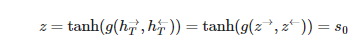




#**Attention**

In [ ]:

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) #....(1)
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2) #.........(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1) #------------(3)

encoder와 동일한 입력 형식을 띄며 attention vector를 반환합니다.

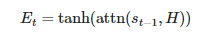

위 코드의 (1)은 hidden state $s_{t-1}$과 forward/backword vector를 통해 만든 $H$를 linear layer(attn)에 통과시킨 값에 tanh를 씌워주는 것으로 energe($E_t$)를 계산합니다. 

image.png

여기서 $E_t$에 가중치 $v$를 곱하여 source 문장에 대해 얼마나 집중해야하는지를 나타낼 수 있습니다. 학습에 따라 계속 업데이트됩니다.(2)

위에서 구한 $\hat a_t$에 softmax를 취하여 $a_t$를 구하는데, 이는 Attention vector 입니다. (3)

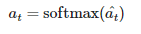



#**Decoder**

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs) #.........(1)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0)) #.........(2)
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))#.......(3)
        
        #prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0)

이전 hidden state인 $s_{t-1}$와 인코더의 모든 hidden state를 담은 $H$, attention vector $a_t$를 통하여 가중치 벡터 $w_t$를 계산합니다.(1)

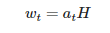

이전 히든스테이트 $s_{t-1}$과 입력된 벡터의 t번째 요소($y_t$)를 임베딩한 $d(y_t)$를 사용하여 $s_t$를 계산합니다.(2)


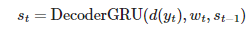

$d(y_t), w_t, s_t$를 linear layer($f$)에 넣어 다음 단어 $\hat{y}_{t+1}$를 예측합니다.(3)

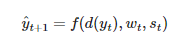

# Seq2Seq model



In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the  tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7852, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5892, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5892, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,516,100 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src.to(device)
            trg = batch.trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Train

전체 epoch 횟수를 변화시켜가며 성능을 비교해봤습니다만, 10회~13회 까지는 전체적으로 Train,Valid 전부 loss가 감소했으나, 그보다 큰 횟수에서는 Valid loss가 증가하는 것이 확인되었습니다.
Translate 함수 테스트를 위해 반복한 결과, 현재는 10회로 고정되었습니다.

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion, device)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 34s
	Train Loss: 5.004 | Train PPL: 149.069
	 Val. Loss: 4.894 |  Val. PPL: 133.424
Epoch: 02 | Time: 1m 32s
	Train Loss: 4.119 | Train PPL:  61.468
	 Val. Loss: 4.656 |  Val. PPL: 105.207
Epoch: 03 | Time: 1m 32s
	Train Loss: 3.475 | Train PPL:  32.289
	 Val. Loss: 3.801 |  Val. PPL:  44.746
Epoch: 04 | Time: 1m 32s
	Train Loss: 2.917 | Train PPL:  18.493
	 Val. Loss: 3.433 |  Val. PPL:  30.961
Epoch: 05 | Time: 1m 32s
	Train Loss: 2.518 | Train PPL:  12.409
	 Val. Loss: 3.288 |  Val. PPL:  26.792
Epoch: 06 | Time: 1m 33s
	Train Loss: 2.213 | Train PPL:   9.145
	 Val. Loss: 3.238 |  Val. PPL:  25.487
Epoch: 07 | Time: 1m 32s
	Train Loss: 1.966 | Train PPL:   7.144
	 Val. Loss: 3.186 |  Val. PPL:  24.192
Epoch: 08 | Time: 1m 32s
	Train Loss: 1.748 | Train PPL:   5.745
	 Val. Loss: 3.211 |  Val. PPL:  24.811
Epoch: 09 | Time: 1m 32s
	Train Loss: 1.587 | Train PPL:   4.887
	 Val. Loss: 3.237 |  Val. PPL:  25.448
Epoch: 10 | Time: 1m 32s
	Train Loss: 1.464 | Train PPL

In [ ]:

model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion, device)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.188 | Test PPL:  24.245 |


#Translate function

학습한 모델을 토대로 번역을 실행하는 코드를 작성해보았습니다만, 결과물이 좋지 않습니다. 계속 수정하는 중에 있으며, 지금 당장은 몇몇 단어들에 대하여 비교적 연관만 있는 단어가 출력되고 있습니다

In [29]:
#translate sentence function

def translate(model, german_sentence, german_field, english_field):
    model.eval()
    
    # Tokenize the German sentence
    german_tokens = german_field.tokenize(german_sentence)
    
    # Convert the German tokens to integers using the German vocabulary
    german_indices = [german_field.vocab.stoi[token] for token in german_tokens]
    
    # Convert the list of integers to a tensor and add a batch dimension
    german_tensor = torch.LongTensor(german_indices).unsqueeze(1)
    
    # Move input and output tensors to the device
    german_tensor = german_tensor.to(device)

    # Pass the German tensor through the encoder
    encoder_outputs, hidden = model.encoder(german_tensor)
    
    # Create a tensor to store the English translation, initialized with the <sos> token
    english_tensor = torch.LongTensor([[english_field.vocab.stoi['<sos>']]]).to(device)
    
    # Initialize a flag variable to keep track of whether or not the <eos> token has been generated
    eos_generated = False

    # Loop until the <eos> token is generated or the maximum translation length is reached
    for i in range(50):
        # Pass the English tensor and the previous hidden state through the decoder
        output, hidden = model.decoder(english_tensor[-1], hidden, encoder_outputs)
        
        # Get the predicted token (as an integer) with the highest probability
        top1 = output.argmax(1)
        
        # Append the predicted token to the English translation tensor
        english_tensor = torch.cat([english_tensor, top1.unsqueeze(0)], dim=0)
        
        # If the predicted token is the <eos> token, set the flag variable and break the loop
        if top1.item() == english_field.vocab.stoi['<eos>']:
            eos_generated = True
            break
    
    # Convert the English translation tensor to a list of integers, excluding the <sos> and <eos> tokens
    english_indices = list(english_tensor.squeeze().detach().cpu().numpy())[1:-1]
    
    # Convert the list of integers to a list of tokens using the English vocabulary
    english_tokens = [english_field.vocab.itos[index] for index in english_indices]
    
    # Join the list of tokens into a string and return it
    english_sentence = ' '.join(english_tokens)
    return english_sentence


In [ ]:
translate(model, 'Das ist ein schönes Haus', SRC, TRG)

'grinder grinder grinder grinder grinder grinder grinder grinder grinder grinder grinder grinder grinder grinder grinder grinder grinder grinder grinder grinder grinder grinder grinder grinder site site site site site .                   '